In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#Importing the required libraries
import os #It is used to connect to the operating system
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) #opencv library
import random #It helps to generate random numbers
import h5py #It lets us store huge amounts of numerical data, and easily manipulate that data from NumPy
import cv2 #It is used to process images and videos to identify objects, faces, or even the handwriting of a human

import matplotlib.pyplot as plt  #plotting library
import matplotlib.image as mpimg #it helps in working with the images
import seaborn as sns # Higher version of matplotlib
from PIL import Image  #It is used to laod the images
from IPython.display import Image, SVG

#Importing required libraries from sklearn
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

#Importing required lib for building CNN model
import tensorflow
from keras import layers, models, optimizers
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
print(os.listdir('../input')) 

['state-farm-distracted-driver-detection']


In [5]:
print(os.listdir('/kaggle/input')) 

['state-farm-distracted-driver-detection']


In [6]:
#Number of training data and testing data we want to train and test on
num_train = 2000
num_test = 2000
img_width = 240 #Image dimensions
img_height = 240
batch_size = 64 #Batch size for gradient descent
nb_epochs = 12 # Number of epochs

In [7]:
# Define paths for train and test
train_path = '../input/state-farm-distracted-driver-detection/imgs/train' # Defining path for training data so that data can be load from there
test_path = '../input/state-farm-distracted-driver-detection/imgs/test/' # Similarly in the case of testing data
classes = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'] # Making a list of classes consisting of our output
driver_img_list = '../input/state-farm-distracted-driver-detection/driver_imgs_list.csv' # Path for img_list
# read image csv file
img_list = pd.read_csv(driver_img_list) #Storing img_list in a dataframe
img_list.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [8]:
for category in classes:
    i=0
    path = os.path.join(train_path,category)
    for img in os.listdir(path):
           i+=1
    print('Numer of instances of class {} in Train: {}'.format(category, i))

i=0
for img in os.listdir(test_path):
    i+=1
print('\nTotal number of images in Test: ', i)

Numer of instances of class c0 in Train: 2489
Numer of instances of class c1 in Train: 2267
Numer of instances of class c2 in Train: 2317
Numer of instances of class c3 in Train: 2346
Numer of instances of class c4 in Train: 2326
Numer of instances of class c5 in Train: 2312
Numer of instances of class c6 in Train: 2325
Numer of instances of class c7 in Train: 2002
Numer of instances of class c8 in Train: 1911
Numer of instances of class c9 in Train: 2129

Total number of images in Test:  79726


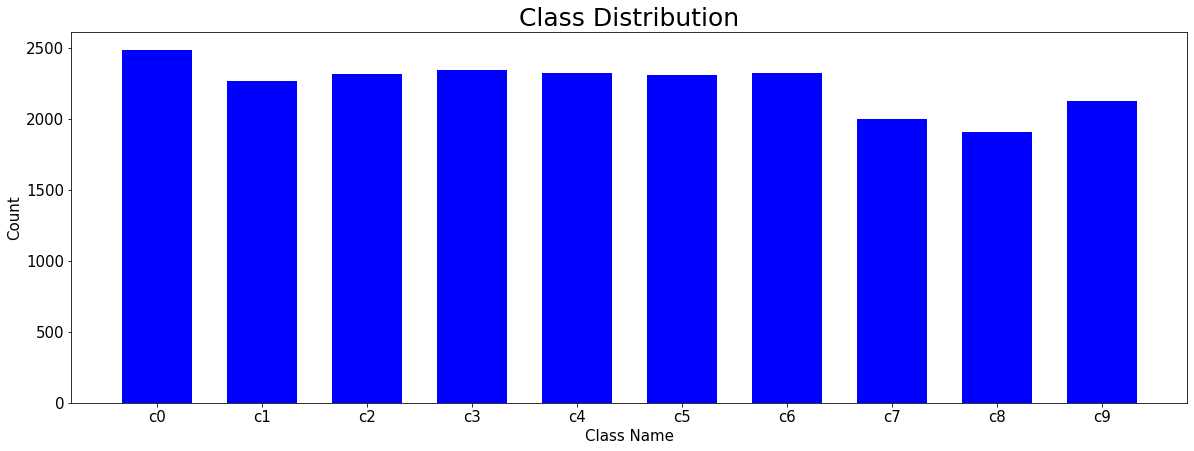

In [9]:
nf = img_list['classname'].value_counts(sort=False) #It tells the number of images in each class
labels = img_list['classname'].value_counts(sort=False).index.tolist() #it stores the labels i.e c0 to c9
y = np.array(nf) # Converting np into a numpy array
width = 1/1.5 # Width of each bar
N = len(y)  
x = range(N)
# Plotting the Number of images vs classes graph
fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)
plt.xticks(x,labels, size=15)
plt.yticks(size=15)
ay.bar(x, y, width, color="blue")
plt.title('Class Distribution',size=25)
plt.xlabel('Class Name',size=15)
plt.ylabel('Count',size=15)
plt.show()

In [10]:
#defining class with their respective action
class_dict = {
    'c0': 'hands on the wheel',
    'c1': 'mobile in right hand',
    'c2': 'talking on the phone with right hand',
    'c3': "mobile in left hand",
    'c4': 'talking on the phone with left hand',
    'c5': 'touching at the dash',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'touching the head',
    'c9': 'looking to the side'
}

Class  c0 :  hands on the wheel


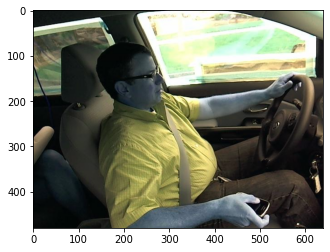



Class  c1 :  mobile in right hand


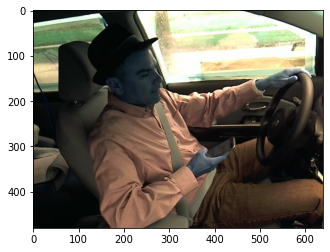



Class  c2 :  talking on the phone with right hand


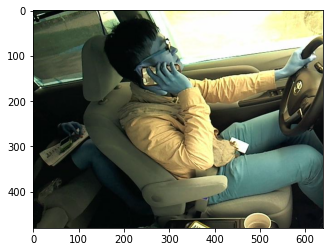



Class  c3 :  mobile in left hand


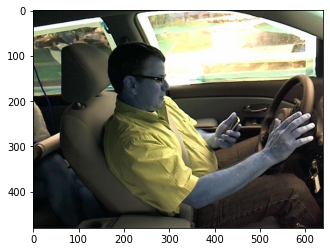



Class  c4 :  talking on the phone with left hand


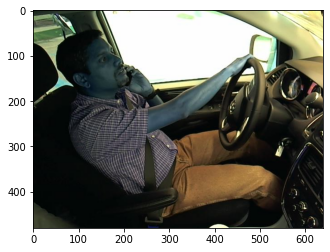



Class  c5 :  touching at the dash


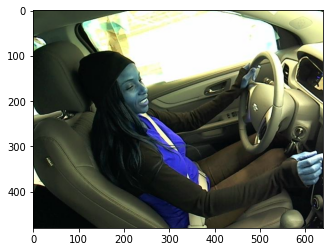



Class  c6 :  drinking


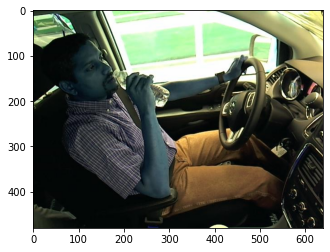



Class  c7 :  reaching behind


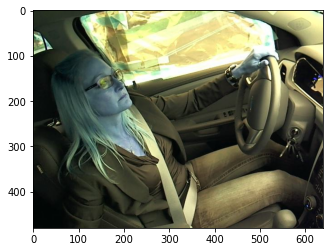



Class  c8 :  touching the head


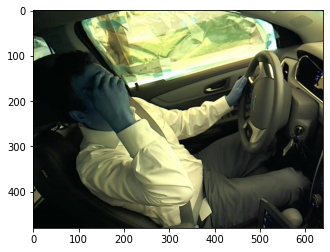



Class  c9 :  looking to the side


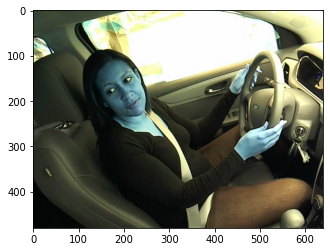

In [11]:
#showing image from each and every class
for i in classes:
    path = os.path.join(train_path, i)
    print("Class ", i, ': ', class_dict[i])
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR) 
        plt.imshow(img_array, cmap='gray')
        plt.show()
        print('\n')
        break

In [12]:
img_array.shape

(480, 640, 3)

Explicitly creating Train and Test data

In [13]:
def create_training_data():
    training_data = []
    for category in classes:
        i=0
        path = os.path.join(train_path,category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            # return num_train instances of each class
            if i < num_train: #Taking first thousand images of each class 
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                # resize image
                new_img = cv2.resize(img_array,(img_width,img_height))
                # get image and class type
                training_data.append([new_img, class_num]) # Appending image along with it's class in training data list
                i+=1
    return training_data

In [14]:
def create_testing_data():
    testing_data = []
    i=0
    for img in os.listdir(test_path):
        # return num_test test images
        if i < num_test: #Taking 1000 images for testing 
            img_array = cv2.imread(os.path.join(test_path,img), cv2.IMREAD_GRAYSCALE)
            new_img = cv2.resize(img_array,(img_width,img_height))
            testing_data.append([img, new_img])
            i+=1
    return testing_data

In [15]:
training_data = create_training_data()
testing_data = create_testing_data()

In [16]:
# Shuffling data 
random.shuffle(training_data)
x, y = list(), list()
for features, label in training_data:
    x.append(features)
    y.append(label)

In [17]:
Y = np_utils.to_categorical(y, num_classes=10) # Converting Y into one hot encoded form
Y[0:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [18]:
X = np.array(x).reshape(-1,img_width,img_height,1)
X[0].shape

(240, 240, 1)

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X, Y,test_size=0.2,random_state=123) 

In [20]:
print("Shape of train images:", X_train.shape)
print("Shape of validation images:", X_test.shape)
print("Shape of labels:", y_train.shape)
print("Shape of labels:", y_test.shape)

Shape of train images: (15928, 240, 240, 1)
Shape of validation images: (3983, 240, 240, 1)
Shape of labels: (15928, 10)
Shape of labels: (3983, 10)


**Creating Sequential model with CNN layers**

In [21]:
model = Sequential()

## CNN 1
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(img_width,img_height,1)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.2))

## CNN 2
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.1))

## CNN 3
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.1))

## CNN 3
model.add(Conv2D(512,(5,5),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.1))

## Dense & Output
model.add(Flatten())
model.add(Dense(units = 256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units = 128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))

2023-01-30 11:45:22.076331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 11:45:22.077315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 11:45:22.198044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 11:45:22.198965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 11:45:22.199756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 238, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 238, 238, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 238, 238, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 238, 238, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 119, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 119, 119, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 119, 119, 128)     7

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
callbacks = [EarlyStopping(monitor='val_acc',patience=5), ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True, verbose=2, mode='auto'),]
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=5,verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

2023-01-30 12:05:33.443371: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 917452800 exceeds 10% of free system memory.


Epoch 1/5
249/249 [==============================] - 226s 907ms/step - loss: 0.0149 - accuracy: 0.9962 - val_loss: 0.0507 - val_accuracy: 0.9847

Epoch 00001: val_loss improved from inf to 0.05070, saving model to weights.h5
Epoch 2/5
249/249 [==============================] - 226s 906ms/step - loss: 0.0135 - accuracy: 0.9960 - val_loss: 0.0270 - val_accuracy: 0.9932

Epoch 00002: val_loss improved from 0.05070 to 0.02701, saving model to weights.h5
Epoch 3/5
249/249 [==============================] - 226s 907ms/step - loss: 0.0118 - accuracy: 0.9968 - val_loss: 0.0247 - val_accuracy: 0.9927

Epoch 00003: val_loss improved from 0.02701 to 0.02472, saving model to weights.h5
Epoch 4/5
249/249 [==============================] - 226s 906ms/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.0313 - val_accuracy: 0.9915

Epoch 00004: val_loss did not improve from 0.02472
Epoch 5/5
249/249 [==============================] - 226s 906ms/step - loss: 0.0161 - accuracy: 0.9955 - val_loss: 0.048

In [32]:
#Predicting on test data
y_val_pred = []
y_val_actual = []
for n in range(len(X_test)):
    preds = model.predict(np.array([X_test[n]]))
    y_val_pred.append(np.argmax(preds[0]))
    y_val_actual.append(np.nonzero(y_test[n])[0][0])

In [33]:
#Predicting on testing data i.e testing images
y_pred = []
for n in range(num_test):
    test_img = np.array(testing_data[n][1]).reshape(-1,img_width,img_height,1)
    preds = model.predict(test_img)
    class_idx = np.argmax(preds[0])
    y_pred.append(class_idx)

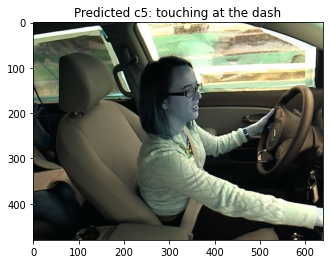

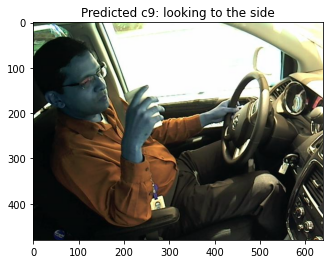

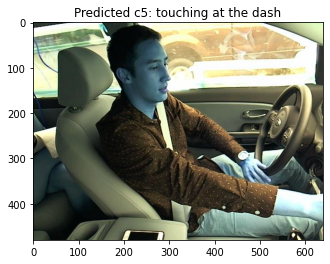

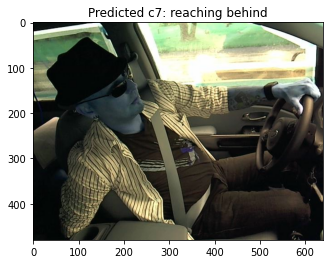

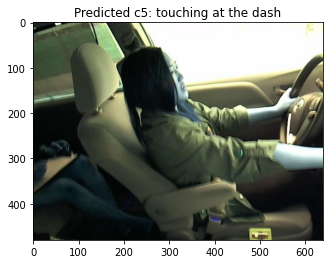

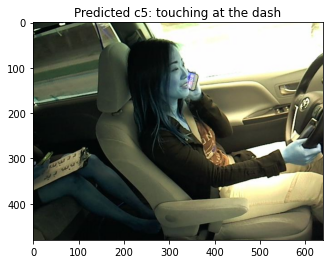

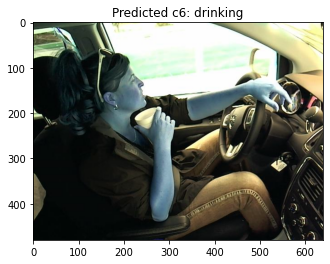

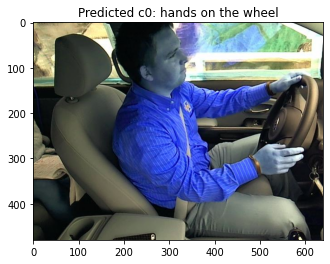

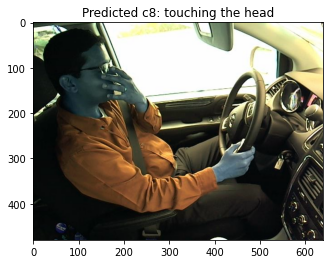

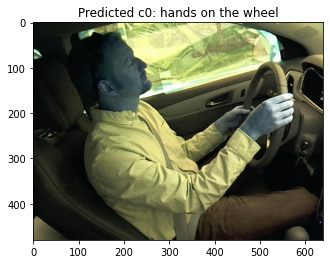

In [35]:
for n in range(1,11):
    img_array = cv2.imread(os.path.join(test_path, testing_data[n][0]), cv2.IMREAD_COLOR)
    plt.imshow(img_array, cmap='gray')
    title_val = y_pred[n]
    plt.title('Predicted c{}: {}'.format(title_val, class_dict['c{}'.format(title_val)]))
    plt.show()
    print('\n')